<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU9proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to Understand Federal Fund Target Rates With Neural Networks and Vice Versa

# Context

8 times a year, the federal reserve board of governers meets to set an interest rate and define the monetary policy for the united states. Since congress is usually to slow to react meaningfully to changes in the economy, the Fed has the best tools for managing the economy. To make their decisions on monetary policy, the fed uses a model based on a number of indicators for the health of the economy. Notably, the dual mandate of the fed is to manage inflation and the unemployment rate.

In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
ffund = pd.read_csv('https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/federal%20funds.csv')# ffund for federal fund
u = ffund.avg_unem.to_numpy()
avg_unem = torch.from_numpy(u)
f = ffund.fed_funds.to_numpy()
fed_funds = torch.from_numpy(f)
c = ffund.CPI.to_numpy()
CPI = torch.from_numpy(c)
o = ffund.Oil_Price.to_numpy()
Oil_Price = torch.from_numpy(o)
ffund

,date﻿,unemployment rate,avg_unem,fed_funds,CPI,Oil_Price
0,6-Apr,4.7,4.923077,4.79,2.675290,69.44
1,6-May,4.6,4.876923,4.94,2.778406,70.84
2,6-Jun,4.6,4.838462,4.99,3.029285,70.95
3,6-Jul,4.7,4.815385,5.24,3.089187,74.41
4,6-Aug,4.7,4.792308,5.25,3.219901,73.04
...,...,...,...,...,...,...
224,24-Dec,4.1,4.015385,4.48,3.746553,70.12
225,25-Jan,4.0,4.030769,4.33,3.625276,75.74
226,25-Feb,4.1,4.061538,4.33,3.516515,71.53
227,25-Mar,4.2,4.084615,4.33,3.257815,68.24


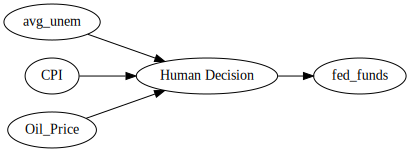

In [33]:
import graphviz
f = graphviz.Digraph('fed_funds dag', filename='fed_funds.gv')
f.attr(rankdir='LR', size='10,10')
f.edge('avg_unem', 'Human Decision')
f.edge('CPI', 'Human Decision')
f.edge('Oil_Price', 'Human Decision')
f.edge('Human Decision', 'fed_funds')
f

The assumption I am making in this project is that the things that the fed says inform their decisions on target interest rates actually do. Oil actually shouldn't have an influence on target interest rates, but I does influence non sticky interest rates like energy which are not included in the non sticky cpi data I am using. It is also important to note that while the fed sets target federal funds rates, the actualy value of the effective federal funds rate (the interest rate at which banks can borrow and lend money between themselves overnight)  is set by the free market in the banks. All the fed does is set a range for where it wants the rate to be and then uses it's various levers including its own ability to borrow to get the rate within that range.

In [3]:
X = avg_unem.unsqueeze(dim=1),CPI.unsqueeze(dim=1), Oil_Price.unsqueeze(dim=1)
y = fed_funds.unsqueeze(dim=1)

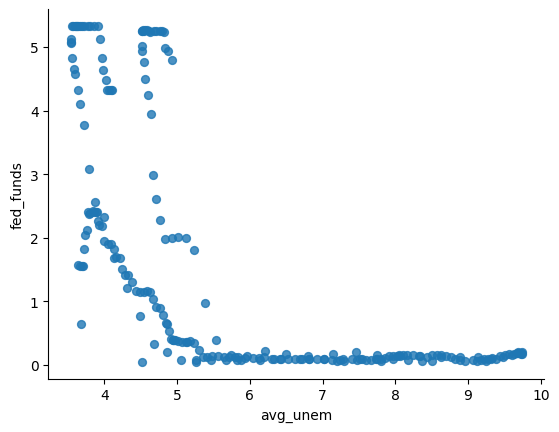

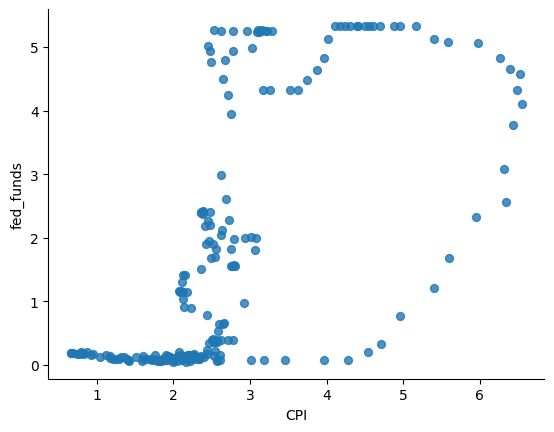

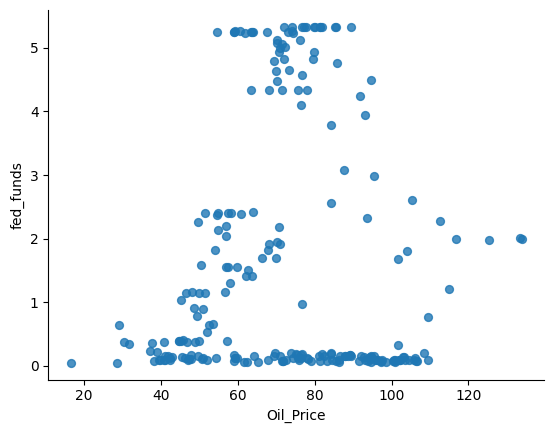

In [4]:
# @title avg_unem vs fed_funds
# gemini code to make it look nicer
from matplotlib import pyplot as plt
ffund.plot(kind='scatter', x='avg_unem', y='fed_funds', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

ffund.plot(kind='scatter', x='CPI', y='fed_funds', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

ffund.plot(kind='scatter', x='Oil_Price', y='fed_funds', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)



Those are definitely some strange graphs. I wonder if part of the reason I appear to be getting 2 separate trends for the relationships has something to do with the reactive nature of federal funds targets. The fed sets its targets due to not only what the data is, but also what it expects the data to be in the future and what the data was in the past. I also wonder if the fact that there are ultimately people in between the data and the decisions made about federal fund target rates has an influence on how this data looks. The oil price is probably my weakest predictor for the data as I kinda just threw it in to see what would happen. What it does show however, is that the federal fund rate is often very high or very low, but not commonly in between those extreme values. For the CPI graph I noticed very curiously that there is a vertical line that exists right around the 2.3 percent inflation rate. Coincidentally, this is roughly the inflation rate the fed targets (really it's 2 percent, but they can only hope for so much). Beyond that, when CPI is high, the federal funds rate appears to increase too, but I only have one major inflationary time period in my data since 2006 so the relationship is limited.

In [5]:
scaler = StandardScaler()
unem_scaled = scaler.fit_transform(
    avg_unem.reshape(-1, 1) #makes it a column vector
    )
cpi_scaled = scaler.fit_transform(
    CPI.reshape(-1, 1)
    )
oil_scaled = scaler.fit_transform(
    Oil_Price.reshape(-1, 1)
    )
X_scaled = np.concatenate((unem_scaled, cpi_scaled, oil_scaled), axis=1)

In [6]:
# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

<ipython-input-7-34ce4591786b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-7-34ce4591786b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [8]:
model_1 = nn.Sequential(
    nn.Linear(in_features=3, out_features=256),  # Added another hidden layer
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),  # Increased neurons
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64), # Added another hidden layer
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),  # Added another hidden layer
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),  # Added another hidden layer
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1),)


In [9]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent


In [10]:
epochs = 10000
for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 2000 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([183, 1])) that is different to the input size (torch.Size([183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 7.60105, Test loss: 6.45381
Epoch: 2000 | Train loss: 5.11960, Test loss: 4.23526
Epoch: 4000 | Train loss: 4.20319, Test loss: 3.48392
Epoch: 6000 | Train loss: 3.95907, Test loss: 3.33212
Epoch: 8000 | Train loss: 3.93163, Test loss: 3.33933


In [11]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)


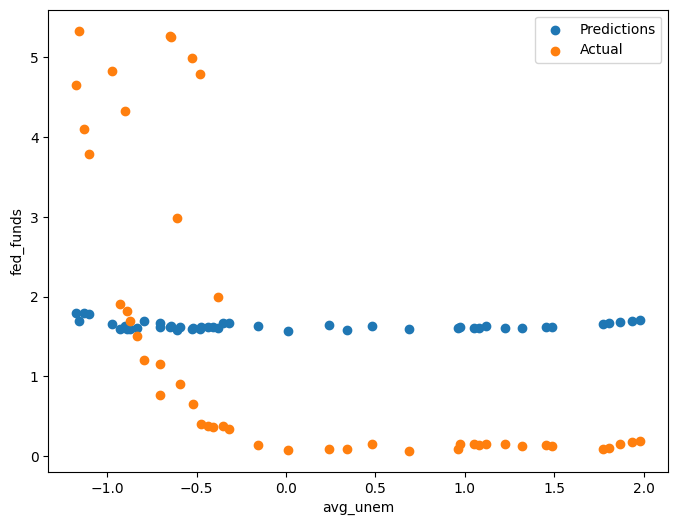

In [12]:
plt.figure(figsize=(8, 6)) # Optional: Set figure size
plt.scatter(X_test[:, 0].detach().numpy(), y_preds.detach().numpy(), label='Predictions')
plt.scatter(X_test[:, 0].detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('avg_unem')
plt.ylabel('fed_funds')
plt.legend()
plt.show()

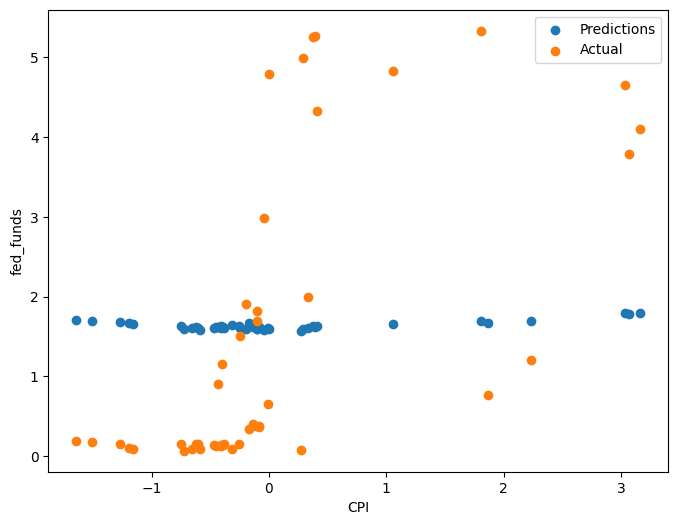

In [13]:
plt.figure(figsize=(8, 6)) # Optional: Set figure size
plt.scatter(X_test[:, 1].detach().numpy(), y_preds.detach().numpy(), label='Predictions')
plt.scatter(X_test[:, 1].detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('CPI')
plt.ylabel('fed_funds')
plt.legend()
plt.show()

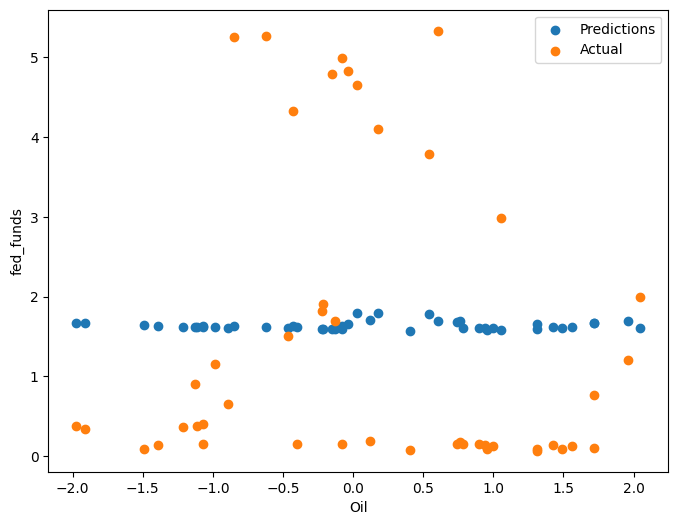

In [14]:
plt.figure(figsize=(8, 6)) # Optional: Set figure size
plt.scatter(X_test[:, 2].detach().numpy(), y_preds.detach().numpy(), label='Predictions')
plt.scatter(X_test[:, 2].detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('Oil')
plt.ylabel('fed_funds')
plt.legend()
plt.show()

My first attempt at a neural network basically just gives me a flat line equivalent to the average federal funds rate. The predictor values are a little weird, but I'm pretty sure that is just because they are scaled. No matter how I change my model in its current state, I can only get a minimum loss of 3.7 because that is the best a strait line can do at predicting the test data. I actually don't think this result is necessarily because the model is bad. The data visualizations I have show a very muddy picture for the relationships between my variables and the federal fund effective rate. There do seem to be relationships in that the data doesn't look at all random, but these relationships don't seem to be remotely like anything I have come across in this class before. Because the data is so strange, I am actually ok with my model predicting the the average federal funds rate because the whole point of this project was to test whether the predictors I chose were good in the first place. Since the predictors evidently don't seem that great, I can conclude that there is a lot more that goes into interest rates than just CPI, Oil prices, and unemployment rates.

I'm actually inclined to believe that this is the best that my model can do and really should do with my data, because I don't have enough economic cycles included in the data set. Basically cycles where



<ipython-input-15-5aa677ea936f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-15-5aa677ea936f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([183, 1])) that is different to the input size (torch.Size([183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 6.66172, Test loss: 6.74965
Epoch: 2000 | Train loss: 4.39755, Test loss: 4.47379
Epoch: 4000 | Train loss: 3.83401, Test loss: 3.90782
Epoch: 6000 | Train loss: 3.82806, Test loss: 3.84381
Epoch: 8000 | Train loss: 3.82660, Test loss: 3.80657


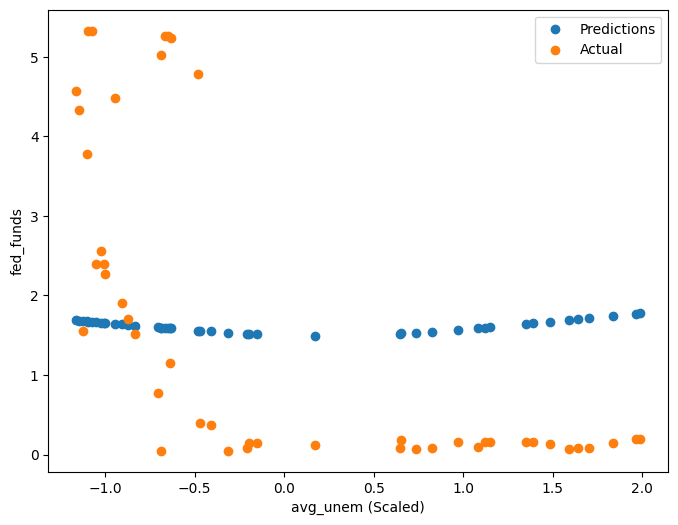

In [15]:
# Select only the avg_unem data
X_unem = avg_unem.unsqueeze(dim=1)
y = fed_funds.unsqueeze(dim=1)

# Scale the avg_unem data
scaler_unem = StandardScaler()
X_unem_scaled = scaler_unem.fit_transform(
    X_unem.reshape(-1, 1)
)

# Split the data into training and testing sets
X_train_unem, X_test_unem, y_train, y_test = train_test_split(X_unem_scaled, y, test_size=0.2)

# Convert to PyTorch tensors
X_train_unem = torch.tensor(X_train_unem, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test_unem = torch.tensor(X_test_unem, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model with 1 input feature
model_unem = nn.Sequential(
    nn.Linear(in_features=1, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1),
)

# Create a loss function
loss_fn_unem = nn.MSELoss()

# Create an optimizer
optimizer_unem = torch.optim.SGD(params=model_unem.parameters(),
                                lr=0.0001)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model_unem.train()
    y_pred_unem = model_unem(X_train_unem)
    loss_unem = loss_fn_unem(y_pred_unem.squeeze(), y_train)
    optimizer_unem.zero_grad()
    loss_unem.backward()
    optimizer_unem.step()

    model_unem.eval()
    with torch.inference_mode():
        test_pred_unem = model_unem(X_test_unem)
        test_loss_unem = loss_fn_unem(test_pred_unem, y_test)

    if epoch % 2000 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss_unem:.5f}, Test loss: {test_loss_unem:.5f}")

# Make predictions with the trained model
model_unem.eval()
with torch.inference_mode():
    y_preds_unem = model_unem(X_test_unem)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_test_unem.detach().numpy(), y_preds_unem.detach().numpy(), label='Predictions')
plt.scatter(X_test_unem.detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('avg_unem (Scaled)')
plt.ylabel('fed_funds')
plt.legend()
plt.show()

This time I got a little bit of curviness in the result, but the predictions still do not match the actual data. I imagine it doesn't help that the test data looks a lot like an 'L' and not a lot like a function.

<ipython-input-19-6a1960c667b3>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-19-6a1960c667b3>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([183, 1])) that is different to the input size (torch.Size([183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 6.93175, Test loss: 3.39762
Epoch: 2000 | Train loss: 4.96390, Test loss: 2.48964
Epoch: 4000 | Train loss: 4.25616, Test loss: 2.50732
Epoch: 6000 | Train loss: 4.09244, Test loss: 2.72941
Epoch: 8000 | Train loss: 4.06856, Test loss: 2.86045


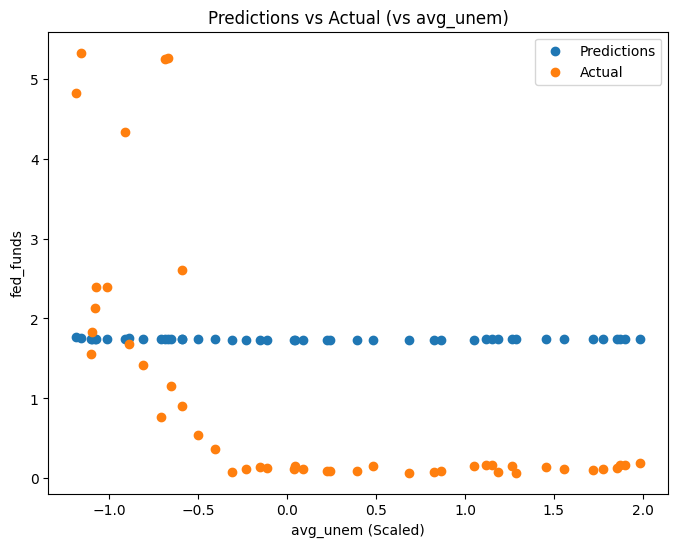

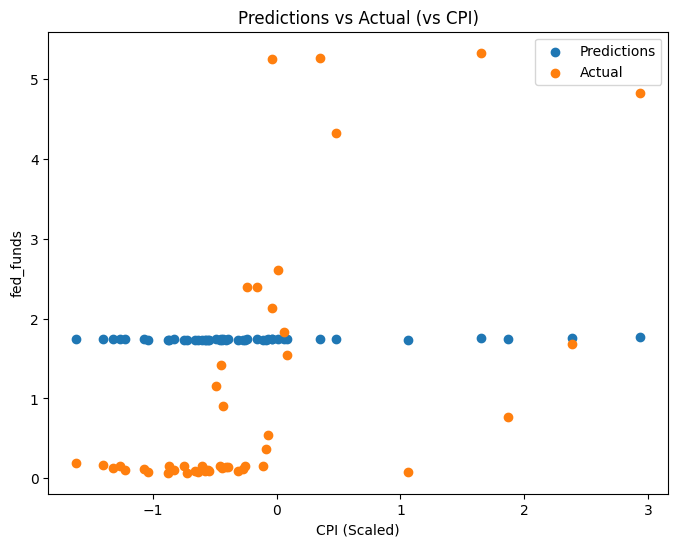

In [19]:
X_unem_cpi = torch.cat((avg_unem.unsqueeze(dim=1), CPI.unsqueeze(dim=1)), dim=1)
y = fed_funds.unsqueeze(dim=1)

# Scale the combined data
scaler_unem_cpi = StandardScaler()
X_unem_cpi_scaled = scaler_unem_cpi.fit_transform(X_unem_cpi.numpy())

# Split the data into training and testing sets
X_train_unem_cpi, X_test_unem_cpi, y_train, y_test = train_test_split(X_unem_cpi_scaled, y, test_size=0.2)

# Convert to PyTorch tensors
X_train_unem_cpi = torch.tensor(X_train_unem_cpi, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test_unem_cpi = torch.tensor(X_test_unem_cpi, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model with 2 input features
model_unem_cpi = nn.Sequential(
    nn.Linear(in_features=2, out_features=256), # Changed in_features to 2
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1),
)

# Create a loss function
loss_fn_unem_cpi = nn.MSELoss()

# Create an optimizer
optimizer_unem_cpi = torch.optim.SGD(params=model_unem_cpi.parameters(),
                                     lr=0.0001)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model_unem_cpi.train()
    y_pred_unem_cpi = model_unem_cpi(X_train_unem_cpi)
    loss_unem_cpi = loss_fn_unem_cpi(y_pred_unem_cpi.squeeze(), y_train)
    optimizer_unem_cpi.zero_grad()
    loss_unem_cpi.backward()
    optimizer_unem_cpi.step()

    model_unem_cpi.eval()
    with torch.inference_mode():
        test_pred_unem_cpi = model_unem_cpi(X_test_unem_cpi)
        test_loss_unem_cpi = loss_fn_unem_cpi(test_pred_unem_cpi, y_test)

    if epoch % 2000 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss_unem_cpi:.5f}, Test loss: {test_loss_unem_cpi:.5f}")

# Make predictions with the trained model
model_unem_cpi.eval()
with torch.inference_mode():
    y_preds_unem_cpi = model_unem_cpi(X_test_unem_cpi)

# Since we have two input features, plotting in 2D against each input individually
# will still show the relationship of the output to each input.

# Plot against avg_unem (scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_test_unem_cpi[:, 0].detach().numpy(), y_preds_unem_cpi.detach().numpy(), label='Predictions')
plt.scatter(X_test_unem_cpi[:, 0].detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('avg_unem (Scaled)')
plt.ylabel('fed_funds')
plt.title('Predictions vs Actual (vs avg_unem)')
plt.legend()
plt.show()

# Plot against CPI (scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_test_unem_cpi[:, 1].detach().numpy(), y_preds_unem_cpi.detach().numpy(), label='Predictions')
plt.scatter(X_test_unem_cpi[:, 1].detach().numpy(), y_test.detach().numpy(), label='Actual')
plt.xlabel('CPI (Scaled)')
plt.ylabel('fed_funds')
plt.title('Predictions vs Actual (vs CPI)')
plt.legend()
plt.show()

Removing the oil data from the model actually increased the test loss by a bit, however, I am going to assume this is more so because there actually is no relationship between oil and fed_funds so a strait line that shows no relationship does a good job.

# Conclusion

For starters, I learned that the relationship between economic indicators and the federal funds rate is complicated. I think to be more successful in predicting federal funds rates with interest rates I would need more data from a broader time span and perhaps from more different countries. I would also have liked to be able to use gdp data although I had some issues since GDP is published on a quarterly basis while all the data I used here is published monthly. The last thing I wanted to add is that it may actually be a good thing that federal funds rates are difficult to predict since one of the major tools that the fed has is the uncertainty that sometimes exists around its rate decitions. Since people and buisinesses make decitions about when to borrow based on their expectations of the future, it may be in the fed's best interest to hide a federal funds rate increase unitl it actually occurs. This is because if people know a rate increase is coming they will actually increase their borrowing thus negating the goal of the rate increase to decrease borrowing.